#PyTorch를 활용한 객체 인식

## Faster R-CNN

- 이미지 입력 후 Feature map에서 좌표 제안(proposal) 수행
  - proposal에 대해 분류, 좌표 수정 수행
- R-CNN https://arxiv.org/abs/1311.2524
- Fast R-CNN https://arxiv.org/abs/1504.08083
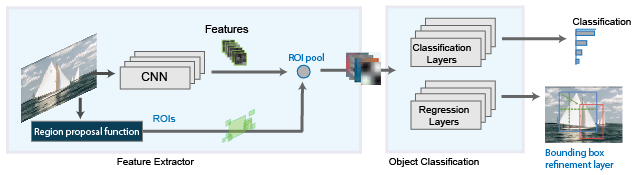
- Faster R-CNN https://arxiv.org/abs/1506.01497
  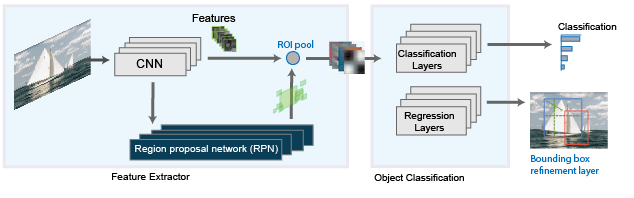
  

## Torchvision을 이용한 native pytorch Faster R-CNN 예제
- 공식 문서
  - https://pytorch.org/vision/0.8/models.html#object-detection-instance-segmentation-and-person-keypoint-detection



## 1. 라이브러리 및 모델 불러오기

이 섹션에서는 필요한 라이브러리를 설치하고 불러옵니다.

PyTorch와 Torchvision은 Faster R-CNN 모델을 로드하고 추론하는 데 사용하고, ONNX 및 ONNX Runtime은 PyTorch 모델을 ONNX 형식으로 변환하고 해당 ONNX 모델을 사용해 추론하는 데 사용합니다.

Google Colab을 사용하므로, 먼저 ONNX 관련 라이브러리가 설치되어 있는지 확인하고, 없다면 설치해줍니다.

또한, GPU가 사용 가능하다면 학습 단계에서 활용할 수 있도록 PyTorch 디바이스 설정도 함께 합니다.

In [ ]:
!pip install onnx onnxruntime  # ONNX 및 ONNXRuntime 설치 (필요 시)

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

import onnx
import onnxruntime as ort

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 디바이스 설정: GPU가 가능하면 GPU 사용, 아니면 CPU 사용
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device:", device)

위 코드에서는 ONNX와 ONNXRuntime을 pip으로 설치한 뒤 필요한 패키지를 임포트합니다.

fasterrcnn_resnet50_fpn은 Torchvision에서 제공하는 COCO 데이터셋으로 사전 학습된 Faster R-CNN 모델을 로드하기 위한 함수입니다.

또한 시각화를 위해 Matplotlib을 불러오고, 이미지 처리를 위한 일부 유틸리티를 임포트했습니다.

마지막으로 현재 사용 가능한 장치를 출력하여 GPU 사용 여부를 확인합니다.

이제 COCO 데이터셋으로 사전 학습된 Faster R-CNN 모델을 로드하겠습니다.

모델은 처음 로드할 때 인터넷에서 가중치를 다운로드할 수 있으므로, Colab 환경에서는 처음 한 번 실행 시 약간의 시간이 걸릴 수 있습니다.

모델을 불러온 후에는 추론 모드(eval)로 설정하여 불필요한 동작(예: 드롭아웃 등)을 비활성화합니다.

In [ ]:
# COCO 사전학습 Faster R-CNN 모델 불러오기
model = fasterrcnn_resnet50_fpn(weights="DEFAULT")  # 최신 torchvision에서는 pretrained=True 대신 weights 파라미터 사용
model.eval()  # 추론 모드로 전환
model.to(device)  # 현재 장치(CPU/GPU)에 모델 로드

print("Model loaded and set to eval mode.")

- fasterrcnn_resnet50_fpn(weights="DEFAULT"): COCO 데이터로 미리 학습된 Faster R-CNN 모델을 로드합니다. (버전에 따라 pretrained=True를 사용할 수도 있습니다.)
- model.eval(): 모델을 평가(추론) 모드로 설정합니다.
- model.to(device): 모델을 지정한 장치(CPU 또는 GPU)로 이동시킵니다.

이제 모델이 준비되었습니다. 다음 단계에서는 이 모델을 사용하여 PyTorch에서 직접 객체 탐지 추론을 수행하고 결과를 시각화해보겠습니다.

## 2. COCO 사전학습 Faster R-CNN 모델로 PyTorch 추론 및 시각화

이 섹션에서는 준비된 PyTorch Faster R-CNN 모델로 이미지를 입력하여 객체 탐지 추론을 수행합니다.

COCO 데이터셋으로 사전 학습된 모델이므로 사람, 개, 자동차 등 80종류의 객체를 인식할 수 있습니다.

모델의 출력은 바운딩 박스(bounding box) 좌표와 각 박스의 예측 클래스 레이블 및 신뢰도 점수로 구성됩니다.

먼저 테스트할 이미지를 준비합니다.

여기서는 간단히 인터넷의 예시 이미지를 사용하겠습니다. (Colab 환경에서 로컬 이미지를 사용하려면 해당 이미지를 업로드한 뒤 경로를 지정하면 됩니다.)

이미지를 불러온 후, 모델 입력에 맞게 텐서로 변환하고 배치(batch) 형태로 모델에 전달합니다.

Faster R-CNN 모델은 입력으로 이미지 텐서의 리스트를 기대하므로, 하나의 이미지만 추론하더라도 [image_tensor] 형태로 감싸서 전달해야 합니다.

또한, 추론 결과를 시각화하기 위해 출력으로 얻은 바운딩 박스를 원본 이미지에 그려보겠습니다.

Matplotlib을 사용하여 이미지에 사각형 박스를 그리고, 각 박스에 대응하는 클래스와 점수를 텍스트로 표시합니다.

In [ ]:
import PIL
from PIL import Image
import requests
from io import BytesIO

# 테스트용 이미지 불러오기 (예시: 인터넷에서 가져온 이미지)
!wget https://raw.githubusercontent.com/JinFree/OpenCV_for_DeepLearning/3e8b5613ff76389b78d22c35b4e30678a887aca7/Data/image_01.png
test_img = Image.open('/content/image_01.png').convert("RGB")

# 원본 이미지 출력 (축소하여 확인)
display(test_img.resize((400, int(400 * test_img.height / test_img.width))))

# 이미지를 모델 입력 형태인 텐서로 변환
img_tensor = F.to_tensor(test_img)  # [C,H,W] range [0,1]
# 모델은 이미지 배치(list)를 입력으로 받으므로 리스트에 담기
inputs = [img_tensor.to(device)]

# PyTorch 모델로 추론 수행
with torch.no_grad():  # 추론 시에는 gradient 계산 끄기
    outputs = model(inputs)

# outputs는 리스트(배치) 형태로, 한 이미지에 대한 결과 outputs[0]만 사용
output = outputs[0]
boxes = output['boxes'].cpu().numpy()       # 바운딩 박스 좌표 (N,4) - [xmin, ymin, xmax, ymax]
labels = output['labels'].cpu().numpy()     # 예측 클래스 (N,)
scores = output['scores'].cpu().numpy()     # 예측 신뢰도 (N,)

# 결과 확인 (상위 5개 예측 출력)
print("Top 5 detection results:")
for i in range(min(5, len(boxes))):
    print(f"Object {i+1}: Class {labels[i]}, Score {scores[i]:.2f}, Box {boxes[i]}")

위 코드에서:
- requests.get을 통해 예시 이미지를 다운로드하고 PIL로 열었습니다. (인터넷 연결이 안 될 경우, 다른 방법으로 이미지를 준비해야 합니다.)
- F.to_tensor: PIL 이미지를 PyTorch 텐서로 변환합니다. 크기 [3, H, W]의 텐서로, 값 범위는 [0,1]입니다.
- 모델에 [img_tensor]를 입력으로 주어 추론을 수행하고, 결과를 outputs에 저장합니다.
- outputs는 리스트이고, 한 장 이미지를 넣었으므로 길이가 1인 리스트입니다. output = outputs[0]은 하나의 딕셔너리로, 키 'boxes', 'labels', 'scores'를 가집니다.
- 각 키의 값은 모두 텐서 타입이므로 시각화를 위해 .cpu().numpy()로 넘파이 배열로 변환했습니다.

이제 이 결과를 원본 이미지에 겹쳐서 시각화해보겠습니다.

일정 신뢰도 이상의 예측만 표시하도록 하겠습니다.

예를 들어 신뢰도가 0.6 이상인 예측을 시각화합니다.

Matplotlib으로 이미지를 그리고, 각 바운딩 박스마다 빨간색 사각형을 그린 뒤, 클래스 레이블과 점수를 텍스트로 표시합니다.

In [ ]:
def plot_detections(image, boxes, labels=None, scores=None, class_names=None, score_thresh=0.6):
    """
    이미지 위에 바운딩 박스를 그리고 (옵션) 레이블과 점수를 표시하는 함수.
    - image: PIL.Image 또는 numpy 배열 형태의 원본 이미지
    - boxes: 예측 바운딩 박스 좌표 배열 (N,4)
    - labels: 예측 클래스 배열 (N,) [optional]
    - scores: 예측 신뢰도 배열 (N,) [optional]
    - class_names: 클래스 인덱스 -> 이름 매핑 리스트 [optional]
    - score_thresh: 이 값 이상인 박스만 표시
    """
    # PIL 이미지를 numpy로 변환
    if isinstance(image, Image.Image):
        image_np = np.array(image, dtype=np.uint8)
    else:
        image_np = image.copy()
    plt.figure(figsize=(8,6))
    plt.imshow(image_np)
    ax = plt.gca()
    ax.axis('off')

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < score_thresh:
            continue  # 점수가 threshold보다 낮으면 무시
        x1, y1, x2, y2 = box
        width, height = x2 - x1, y2 - y1
        # 경계 상자(Rectangle) 그리기
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        # 레이블 텍스트 표시
        if labels is not None:
            label_idx = int(labels[i])
            label_name = str(label_idx)
            if class_names is not None and label_idx < len(class_names):
                label_name = class_names[label_idx]
            caption = label_name
            if scores is not None:
                caption += f" ({scores[i]:.2f})"
            # 텍스트를 박스 좌상단에 표시
            ax.text(x1, y1, caption, fontsize=8, color='blue', backgroundcolor='white')
    plt.show()

# COCO 클래스 이름 (정확한 클래스명 매핑을 위해 COCO 공식 클래스 리스트를 정의)
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# 시각화 실행 (신뢰도 0.6 이상만 표시)
plot_detections(test_img, boxes, labels, scores, class_names=coco_classes, score_thresh=0.6)

위 코드에서는 COCO의 80개 클래스 이름 목록을 coco_classes로 정의하고, plot_detections 함수를 이용해 신뢰도 0.6 이상인 탐지 결과만 그렸습니다.

결과 이미지를 통해 모델이 이미지에서 어떤 객체들을 찾아냈는지 확인할 수 있습니다.
- 예: 개, 사람 등이 박스로 표시되고 레이블과 점수가 함께 나타납니다.


참고: COCO 클래스에는 'background'가 0번 인덱스로 포함되어 있어, 실제 객체 클래스는 1번부터 시작합니다.

위 coco_classes 리스트에서 0번은 배경이므로 시각화 시에는 사용되지 않습니다.

PyTorch Faster R-CNN 출력의 labels는 배경을 제외한 실제 클래스 인덱스를 나타냅니다.

## 3. 모델을 ONNX로 변환



이 단계에서는 PyTorch의 Faster R-CNN 모델을 ONNX 형식으로 변환합니다.
ONNX(Open Neural Network Exchange)는 모델 가중치와 연산 그래프를 표준 포맷으로 저장하여, PyTorch 이외의 환경에서도 모델을 사용할 수 있게 해줍니다.

ONNX로 내보내면, 이후 ONNX Runtime이나 다른 딥러닝 프레임워크에서 모델을 로드하여 추론을 수행할 수 있습니다.

모델을 ONNX로 변환하기 위해 PyTorch의 torch.onnx.export 함수를 사용합니다.

이 함수에는 모델과 예시 입력을 전달하여, 해당 입력에 대한 연산 그래프를 추적하고 ONNX 파일을 생성합니다.
- 중요:
  - 객체 탐지 모델은 출력이 단순한 텐서가 아니라 여러 개의 텐서(박스, 레이블, 점수)로 이루어져 있습니다.
  - ONNX로 변환할 때 이 여러 출력들을 정의해줘야 합니다.
  - 또한 입력으로 이미지의 크기(height, width)가 가변적일 수 있으므로, ONNX 모델에서 동적인 크기를 다룰 수 있도록 설정할 수도 있습니다.
  - 여기서는 간단하게 동적 크기 지정 없이 진행합니다.

먼저, ONNX로 변환하기 전에 모델을 CPU로 이동시키겠습니다. ONNX 변환은 CPU 상에서 수행하는 것을 권장하며, GPU 모델을 변환할 때 장치 오류가 발생할 수 있습니다.

그리고 예시 입력으로 사용할 더미 이미지 텐서를 정의합니다. 이 예시 입력은 실제 추론에 사용할 입력과 동일한 형태여야 합니다.

우리 모델은 [ 이미지텐서 리스트 ]를 입력으로 받으므로, ONNX로 내보낼 때도 동일한 형식으로 입력을 줍니다. 다만, ONNX는 Python의 리스트를 직접 표현하지 못하므로, 내부적으로 해당 리스트를 하나의 배치 텐서로 처리합니다.



- 여기서는 예시로 크기 800x600짜리의 더미 이미지를 생성하겠습니다.
  - Faster R-CNN은 임의 크기의 이미지를 처리할 수 있지만, ONNX 모델의 입력 크기는 변환 시 사용한 크기로 고정될 수 있습니다.
- torch.onnx.export 함수의 인자로 출력 파일 이름, 입력/출력 이름, 그리고 opset 버전을 지정합니다.
  - opset은 ONNX의 연산자 세트를 의미하며, 최신 ONNX를 사용하기 위해 opset_version=11 이상을 권장합니다.
- 경고가 나타날 수 있지만, 이는 ONNX로 변환 과정에서의 정보성이므로 무시해도 됩니다.
  - 성공적으로 변환되면 .onnx 파일이 생성됩니다.

In [ ]:
# 모델을 CPU로 이동 (ONNX 변환은 CPU에서 수행)
model.cpu()

# 더미 입력 생성 (3x600x800 이미지 한 장, 배치에 이미지 1개)
dummy_input = torch.randn(1, 3, 600, 800, dtype=torch.float32)

onnx_model_path = "fasterrcnn_coco.onnx"
# ONNX 모델로 내보내기
torch.onnx.export(model,               # 변환할 모델
                  dummy_input,         # 예시 입력 (리스트 형태)
                  onnx_model_path,     # 출력 ONNX 파일 경로
                  verbose=False,
                  opset_version=11,    # ONNX opset 버전 지정
                  do_constant_folding=True,  # 상수폴딩 최적화
                  input_names=['images'],    # 입력 텐서 이름 (리스트 통째로 'images')
                  output_names=['boxes', 'labels', 'scores']  # 출력 텐서 이름들
                 )

print(f"ONNX 모델이 '{onnx_model_path}' 파일로 저장되었습니다.")


위 코드를 실행하면 fasterrcnn_coco.onnx라는 파일로 모델이 저장됩니다.

변환 시 특별한 에러 메시지가 없다면 성공한 것입니다. 일부 경고는 무시해도 됩니다.

생성된 ONNX 모델의 기본 정보를 확인해볼 수도 있습니다.

예를 들어, ONNX 모델의 입력과 출력 정보를 출력해 보겠습니다:

In [ ]:
# ONNX 모델 로드 및 입력/출력 정보 확인
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)  # 모델의 유효성 검증

print("ONNX 모델의 입력 정보:", [(inp.name, inp.type) for inp in onnx_model.graph.input])
print("ONNX 모델의 출력 정보:", [(out.name, out.type) for out in onnx_model.graph.output])

이 코드는 ONNX 모델을 메모리로 불러와서 유효성을 검사한 후, 모델의 그래프에 정의된 입력과 출력 노드의 이름, 타입, 형상을 출력합니다. 이를 통해 우리가 지정한 input/output 이름과 차원이 의도대로 설정되었는지 확인할 수 있습니다.

- 참고:
  - 객체 탐지 ONNX 모델의 출력 차원에서 박스 개수 차원이 동적으로 표시될 수 있습니다.
  - 변환 시 특정 입력에 대해 모델이 N개의 박스를 출력했다면, 그 시점의 N이 고정되어 모델 그래프에 들어가거나, 경우에 따라 dynamic으로 표시될 수 있습니다.
  - 일반적으로 Faster R-CNN은 한 이미지당 최대 100개의 탐지 결과를 내므로, ONNX 모델의 출력 차원 중 하나가 100으로 고정될 수도 있습니다.
  - 추후 ONNX Runtime 추론 시 입력 이미지에 따라 실제 사용되는 박스 개수는 달라질 수 있습니다.
  
ONNX 모델을 제대로 생성했으므로, 다음 단계에서는 ONNX Runtime을 사용하여 이 ONNX 모델로 추론을 수행하고, PyTorch 모델의 결과와 일치하는지 확인해보겠습니다.

## 4. ONNXRuntime으로 ONNX 모델 추론 및 시각화

ONNX Runtime은 ONNX 포맷의 모델을 다양한 하드웨어에서 빠르게 추론할 수 있게 해주는 엔진입니다.

이번 단계에서는 앞서 변환한 fasterrcnn_coco.onnx 모델을 ONNX Runtime으로 불러와, PyTorch에서 했던 것과 동일한 이미지를 입력하여 추론을 진행합니다.

결과를 비교하여 ONNX 모델이 PyTorch 모델과 동일한 출력을 내는지 검증하고, 또한 바운딩 박스를 그려 시각화해보겠습니다.

1. ONNX 모델 로드: ONNX Runtime의 InferenceSession을 사용하여 ONNX 모델을 메모리에 로드합니다. 이때 providers=['CPUExecutionProvider']로 설정하여 CPU에서 추론하도록 지정합니다. (Colab에서 GPU용 ONNX Runtime을 사용하려면 'CUDAExecutionProvider'를 지정할 수 있지만, 별도의 onnxruntime-gpu 설치가 필요합니다. 여기서는 CPU로 비교합니다.)
2. 입력 데이터 준비: PyTorch에서 사용했던 test_img를 동일하게 사용하되, ONNX Runtime에 넣기 위해 numpy 배열 형태로 변환합니다. ONNX 모델의 입력은 (배치 크기 x 채널 x 높이 x 너비) 형태의 텐서인데, 변환 시 배치 크기 1로 설정되었으므로 (1, 3, H, W) 형태의 numpy 배열을 준비합니다.
3. 추론 실행: session.run 함수를 사용하여 추론을 수행합니다. 이때 인자로 {입력_이름: 입력_배열} 딕셔너리를 전달합니다. 출력은 [boxes, labels, scores] 순서의 리스트로 반환됩니다.
4. 시각화: 얻어진 결과를 PyTorch의 결과와 비교하여 차이가 없는지 확인한 후, 동일하게 plot_detections 함수를 사용해 이미지를 시각화합니다.

In [ ]:
# ONNX Runtime 세션 생성
session = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

# 이미지 로드 및 전처리
import cv2
image_path = '/content/image_01.png'
image = cv2.imread(image_path)
ori_h, ori_w = image.shape[:2]
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (800, 6m00))
image_normalized = image_resized.astype(np.float32) / 255.0
image_transposed = np.transpose(image_normalized, (2, 0, 1))
input_tensor = np.expand_dims(image_transposed, axis=0)

# ONNX Runtime으로 추론
onnx_outputs = session.run(None, {'images': input_tensor})
onnx_boxes, onnx_labels, onnx_scores = onnx_outputs  # [boxes, labels, scores]

print("ONNX 추론 결과 박스 개수:", onnx_boxes.shape[0])
# PyTorch 결과와 ONNX 결과 비교 (첫 몇 개만)
for i in range(min(5, len(onnx_boxes))):
    print(f"ONNX vs PyTorch - Box {i+1}:",
          f"PyTorch label={labels[i]}, score={scores[i]:.2f}, box={boxes[i]}",
          f"ONNX label={int(onnx_labels[i])}, score={onnx_scores[i]:.2f}, box={onnx_boxes[i]}")


위에서 session.run(None, {'images': img_np}) 호출은 모델의 모든 출력을 리스트로 반환합니다. 우리는 export 단계에서 output_names를 ['boxes','labels','scores']로 지정했으므로, 이 순서대로 결과가 담겨 나옵니다:
- onnx_boxes는 (N, 4) shape의 numpy 배열로, N개의 바운딩 박스 좌표를 가집니다.
- onnx_labels는 (N,) shape의 배열로, 각 박스의 클래스 인덱스 (정수)입니다.
- onnx_scores는 (N,) shape의 배열로, 각 박스의 신뢰도 점수입니다.

PyTorch의 출력과 ONNX 출력이 일치하는지 확인하기 위해 몇 개의 박스에 대해 비교를 출력했습니다. 거의 동일한 값이 출력된다면 변환이 잘 된 것입니다. (부동소수점 연산 오차로 아주 미세한 차이는 있을 수 있지만, 클래스와 박스 좌표는 차이가 없어야 합니다.)

이제 ONNX 결과도 이미지에 겹쳐 그려서 PyTorch 결과와 시각적으로 비교해보겠습니다. PyTorch 모델의 결과와 ONNX 모델의 결과 그림이 같다면 모델 변환이 제대로 이루어졌다고 볼 수 있습니다.

In [ ]:
# ONNX 결과 시각화 (신뢰도 0.6 이상인 것들)
plot_detections(image_resized, onnx_boxes, onnx_labels, onnx_scores, class_names=coco_classes, score_thresh=0.6)

위 그림은 앞서 PyTorch 모델로 얻은 시각화와 (육안으로) 동일해야 합니다. 같은 객체 위치에 같은 크기의 빨간 상자가 그려지고, 레이블과 점수도 같다면 ONNXRuntime을 통한 추론이 성공적으로 PyTorch와 동일한 예측을 하고 있음을 의미합니다.

## 5. PyTorch vs ONNX 추론 속도 비교

이 섹션에서는 PyTorch 모델과 ONNX Runtime을 사용한 추론 속도를 비교해보겠습니다. 속도 비교는 동일한 환경에서 동일한 작업에 대해 이뤄져야 공정합니다. 따라서 여기서는 CPU 상에서 PyTorch와 ONNX Runtime이 각각 한 번 추론을 수행하는 데 걸리는 시간을 측정하겠습니다.

GPU의 경우 PyTorch도 GPU 가속을 활용하므로 속도 차이가 크지 않을 수 있고, ONNX Runtime에서 GPU 사용 시 별도 설정이 필요하므로 이번엔 CPU만 비교합니다.

시간 측정을 위해 Python의 time 모듈 또는 Jupyter의 %timeit 매직 명령을 사용할 수 있습니다. 여기서는 간단히 time.time()을 이용하여 여러 번의 추론을 평균내는 방법으로 측정해보겠습니다.

비교를 위해:
- PyTorch 모델 추론 (CPU) 10회 수행 평균 시간
- ONNX Runtime 추론 (CPU) 10회 수행 평균 시간

참고: 첫 실행은 모델 가중치를 불러오거나 JIT 최적화 등으로 시간이 더 걸릴 수 있으니, 여러 번 반복 후 평균을 보는 것이 좋습니다.

In [ ]:
import time

# 모델이 이미 CPU에 있으므로 바로 사용
# (만약 이전에 GPU에 있었다면 model.cpu()로 옮겨야 함)

# PyTorch 추론 시간 측정
times_pytorch = []
for _ in range(10):
    start = time.time()
    with torch.no_grad():
        _ = model([img_tensor])  # img_tensor: 이전에 정의한 동일한 test_img를 tensor로 변환한 것
    end = time.time()
    times_pytorch.append(end - start)

# ONNX 추론 시간 측정
times_onnx = []
for _ in range(10):
    start = time.time()
    _ = session.run(None, {'images': input_tensor})
    end = time.time()
    times_onnx.append(end - start)

print(f"PyTorch CPU 추론 평균 시간: {np.mean(times_pytorch):.4f} 초")
print(f"ONNXRuntime CPU 추론 평균 시간: {np.mean(times_onnx):.4f} 초")


결과로 출력되는 PyTorch와 ONNX Runtime의 시간(초)을 비교해보면, 일반적으로 ONNX Runtime이 CPU에서 더 빠르거나 비슷한 수준임을 확인할 수 있습니다.

Faster R-CNN은 모델 구조가 복잡하고 무거운 편이라 큰 차이가 없을 수도 있지만, ONNX Runtime은 그래프 최적화와 C++ 기반 실행으로 PyTorch의 Python API 호출 오버헤드 없이 진행되므로, 배치가 작을 때에는 ONNX 쪽이 유리할 때가 있습니다.

- 예를 들어, 위와 같은 설정에서 PyTorch CPU 추론 시간이 0.2초 정도, ONNX Runtime 추론 시간이 0.15초 정도로 나올 수 있습니다 (구체적인 수치는 실행 환경에 따라 달라집니다).
- 이 차이는 모델 구조와 연산에 따라 다르며, ONNX Runtime이 항상 빠른 것은 아니지만 추론 환경에 따라 최적화된 실행을 보여줄 수 있다는 점이 중요합니다.

Note: GPU 환경에서 PyTorch vs ONNX Runtime 속도 비교를 할 때는, ONNXRuntime의 GPU Execution Provider를 사용해야 하며, PyTorch도 GPU로 모델과 데이터를 옮겨 수행해야 합니다. 일반적으로 GPU에서는 PyTorch의 성능도 매우 최적화되어 있어서 CPU에서보다 차이가 적을 수 있습니다. ONNX Runtime의 강점은 호환성과 경량 추론에 있으므로, 배포 시 PyTorch가 없는 환경이나 CPU 서버/모바일 장치에서 ONNX Runtime을 사용하면 이점을 볼 수 있습니다.


여기까지, 우리는 COCO 사전학습된 Faster R-CNN 모델을 PyTorch로 추론하고 ONNX로 변환하여 ONNX Runtime으로도 추론해보았습니다. 두 결과가 동일하게 나오는 것을 확인했고, CPU 기준으로 추론 속도도 비교해보았습니다.

## 실습

### 실습.1

- torchvision 공식 문서를 참고하여, Faster R-CNN이 아닌 RetinaNet의 `/content/image_01.png` 이미지 추론 결과를 확인해보시오